Model Evaluation

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image

import torchvision.transforms.functional as tf
from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
torch.manual_seed(2)

In [3]:
# Number of Historical Days used as Input!
num_days_history = 84

In [4]:
base_folder = "/g/data/w28/ad0033/GNN/"

In [5]:
curr_dir = "flash_drought_ml_retrain/"
curr_folder = base_folder + curr_dir

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
# Building mask to remove invalid areas
file_path = base_folder + "flash_drought_ml/data/FD/20010310.z_score.tif"
im = Image.open(file_path)
mask = tf.to_tensor(im)
mask[mask >= 0] = True
mask[mask < 0] = False
mask = mask.bool().to(device)
print(f"Number of valid points:, {torch.sum(mask):,}")

Number of valid points:, 152,661


In [8]:
image_shape = mask.shape

In [9]:
class CustomDataset(Dataset):
    def __init__(self, start_pt, num_pts):
        self.start_pt = start_pt
        self.num_pts = num_pts
        self.factor = 1

        base = base_folder + "flash_drought_ml/data/"
        self.input_folder = base + "input/"
        self.output_folder = base + "output/"
        self.input_files = sorted(os.listdir(self.input_folder))
        self.output_files = sorted(os.listdir(self.output_folder))
        
        months = torch.arange(12)
        months_sin = torch.sin(2 * torch.pi * months / 12).unsqueeze(1).unsqueeze(2)
        months_cos = torch.cos(2 * torch.pi * months / 12).unsqueeze(1).unsqueeze(2)
        self.months_sin = months_sin.repeat(1, image_shape[1], image_shape[2])
        self.months_cos = months_cos.repeat(1, image_shape[1], image_shape[2])
        
        y_axis = torch.arange(image_shape[1]).unsqueeze(0).unsqueeze(2).repeat(1, 1, image_shape[2]) / image_shape[1]
        x_axis = torch.arange(image_shape[2]).unsqueeze(0).unsqueeze(1).repeat(1, image_shape[1], 1) / image_shape[2]
        self.position = torch.cat([y_axis, x_axis], 0)

        end_pt = start_pt + num_pts * self.factor

        assert end_pt <= len(self.output_files), f"{end_pt} > {len(self.output_files)}"

    def __len__(self):
        return self.num_pts

    def __getitem__(self, idx):
        idx = idx * self.factor
        output_file_name = self.output_files[self.start_pt + idx]
        month = int(output_file_name[4:6])
        input = []
        for i in range(num_days_history):
            # assert self.start_pt + idx + 67 - i >= 0
            input.append(torch.load(self.input_folder + self.input_files[self.start_pt + idx + 67 - i]))
        input.append(self.months_sin[month-1].unsqueeze(0))
        input.append(self.months_cos[month-1].unsqueeze(0))
        input.append(self.position)
        input = torch.cat(input, 0)
        output = torch.load(self.output_folder + output_file_name)
        return input, output, output_file_name

In [10]:
dataloader = DataLoader(CustomDataset(6475+90, 10), batch_size=2, shuffle=False)
train_features, train_labels, file_names = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(file_names)

Feature batch shape: torch.Size([2, 508, 676, 407])
Labels batch shape: torch.Size([2, 1, 676, 407])
('20190301.pt', '20190302.pt')


Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        convs = []
        bns = []
        dropouts = []
        conv_chs = [6 * num_days_history + 4, 512, 256, 128, 64, 32, 16, 8]
        for i in range(len(conv_chs) - 1):
            convs.append(nn.Conv2d(conv_chs[i], conv_chs[i + 1], kernel_size=(3,3), padding="same"))
            bns.append(nn.BatchNorm2d(conv_chs[i + 1]))
            dropouts.append(nn.Dropout2d(0.1))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)
        self.dropouts = nn.ModuleList(dropouts)
        self.act = nn.ReLU()
        self.final_conv = nn.Conv2d(conv_chs[-1], 1, kernel_size=(3,3), padding="same")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for conv, bn, dropout in zip(self.convs, self.bns, self.dropouts):
            x = self.act(bn(conv(x)))
            x = dropout(x)
        x = self.sigmoid(self.final_conv(x))
        return x

In [14]:
BATCH_SIZE = 2
train_dataloader = DataLoader(CustomDataset(22, 5410-22), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
val_dataloader = DataLoader(CustomDataset(5410, 6141-5410), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_dataloader = DataLoader(CustomDataset(6141, 1826), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [15]:
train_steps = len(train_dataloader.dataset) // BATCH_SIZE
batch_mask = mask.repeat(1, 1, 1, 1)

In [16]:
model = Net().to(device)
print(model)

Net(
  (convs): ModuleList(
    (0): Conv2d(508, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (bns): ModuleList(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [17]:
def get_metrics(dataloader, threshold=0.5):
    model.eval()

    correct_num = 0
    correct_denom = 0
    recall_num = 0
    recall_denom = 0
    precision_num = 0
    precision_denom = 0
    recall_neg_num = 0
    recall_neg_denom = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            y_pred = model(inputs)
            pred = y_pred > threshold

            curr_mask = batch_mask.repeat(pred.shape[0], 1, 1, 1)
            pred = pred[curr_mask]
            labels = labels[curr_mask]
            
            correct_num += (pred == labels).float().sum().item()
            correct_denom += labels.numel()
            recall_num += (pred[labels == 1] == labels[labels == 1]).float().sum().item()
            recall_denom += labels[labels == 1].numel()
            precision_num += (pred[pred == 1] == labels[pred == 1]).float().sum().item()
            precision_denom += labels[pred == 1].numel()
            recall_neg_num += (pred[labels == 0] == labels[labels == 0]).float().sum().item()
            recall_neg_denom += labels[labels == 0].numel()
        
        correct = 0
        if correct_denom > 0:
            correct = correct_num / correct_denom
        recall = 0
        if recall_denom > 0:
            recall = recall_num / recall_denom
        precision = 0
        if precision_denom > 0:
            precision = precision_num / precision_denom
        recall_neg = 0
        if recall_neg_denom > 0:
            recall_neg = recall_neg_num / recall_neg_denom
        
        torch.cuda.empty_cache()
        
        return correct, recall, precision, recall_neg

In [18]:
checkpoint = torch.load(curr_folder + "model.pt")
model.load_state_dict(checkpoint)
model.eval()

Net(
  (convs): ModuleList(
    (0): Conv2d(508, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (bns): ModuleList(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [19]:
def calc_f1_score(precision, recall):
    if (recall + precision) > 1e-6:
        return 2 * (recall * precision) / (recall + precision)
    return 0

In [20]:
def calc_balanced_accuracy(recall, recall_neg):
    return (recall + recall_neg) / 2

In [22]:
val_correct, val_recall, val_precision, val_recall_neg = get_metrics(val_dataloader)

print("[Validation Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f, Recall_Neg: %.4f" % (100*val_correct, 100*val_recall, 100*val_precision, 100*val_recall_neg))

print("Model Value:", calc_f1_score(val_recall, val_precision))

[Validation Metrics] Accuracy: 96.2453, Recall: 63.6292, Precision: 29.1779, Recall_Neg: 96.9000
Model Value: 0.4000910588381837


In [23]:
test_correct, test_recall, test_precision, test_recall_neg = get_metrics(test_dataloader)

print("[Test Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f, Recall_Neg: %.4f" % (100*test_correct, 100*test_recall, 100*test_precision, 100*test_recall_neg))

[Test Metrics] Accuracy: 94.5238, Recall: 64.8501, Precision: 29.2385, Recall_Neg: 95.3946


In [24]:
calc_f1_score(test_precision, test_recall)

0.4030502569182612

In [25]:
calc_balanced_accuracy(test_recall, test_recall_neg)

0.8012236373337891

In [ ]:
train_correct, train_recall, train_precision, train_recall_neg = get_metrics(train_dataloader)

print("[Train Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f, Recall_Neg: %.4f" % (100*train_correct, 100*train_recall, 100*train_precision, 100*train_recall_neg))

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

2024-08-25 07:17:12.997193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 07:17:13.767314: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [23]:
def extract_scalar_data(log_dir):
    scalar_data = {}
    for event in tf.compat.v1.train.summary_iterator(log_dir):
        for value in event.summary.value:
            if value.tag not in scalar_data:
                scalar_data[value.tag] = {'step': [], 'value': []}
            scalar_data[value.tag]['step'].append(event.step)
            scalar_data[value.tag]['value'].append(value.simple_value)
    return scalar_data

log_dir_analyze = base_folder + "logs/smaller2/20240722-160303/events.out.tfevents.1721628183.gadi-gpu-v100-0097.gadi.nci.org.au.389032.1"
scalar_data = extract_scalar_data(log_dir_analyze)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [24]:
print(scalar_data.keys())

dict_keys(['Loss/train', 'Accuracy/train', 'Recall/train', 'Precision/train', 'Accuracy/validation', 'Recall/validation', 'Precision/validation'])


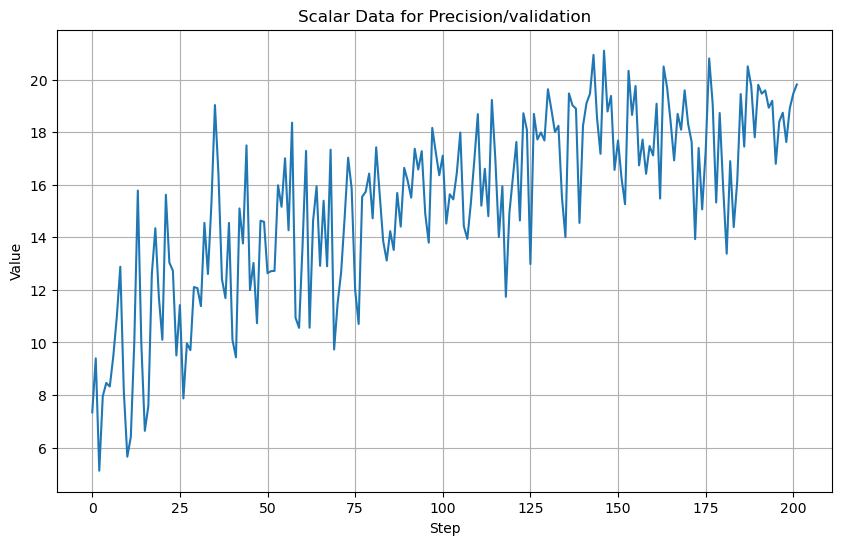

In [25]:
def plot_scalar_data(scalar_data, tag):
    plt.figure(figsize=(10, 6))
    plt.plot(scalar_data[tag]['step'], scalar_data[tag]['value'], linestyle='-')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(f'Scalar Data for {tag}')
    plt.grid(True)
    plt.show()

tag_to_plot = 'Precision/validation'
plot_scalar_data(scalar_data, tag_to_plot)

Calculate Metrics

In [27]:
from torchmetrics.classification import BinaryAUROC
from sklearn.metrics import precision_recall_curve, auc, f1_score
import numpy as np

In [28]:
check_dataloader = DataLoader(CustomDataset(6141, 1826), batch_size=1, shuffle=False, num_workers=8)

In [29]:
auroc = BinaryAUROC().to(device)

all_y_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in check_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(0)
        y_preds = model(inputs).squeeze(0)
        y_preds_final, labels_final = y_preds[mask], labels[mask]
        
        auroc.update(y_preds_final, labels_final)
        all_y_preds.append(y_preds_final.cpu().numpy())
        all_labels.append(labels_final.cpu().numpy())
        
        torch.cuda.empty_cache()

all_y_preds = np.concatenate(all_y_preds)
all_labels = np.concatenate(all_labels)

In [30]:
auroc_value = auroc.compute()
print(f'AUROC: {auroc_value}')

AUROC: 0.938366174697876


In [31]:
precision, recall, _ = precision_recall_curve(all_labels, all_y_preds)
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc}')

PR AUC: 0.41302200048136267


In [32]:
# Random Model
all_y_preds_random = np.random.rand(len(all_y_preds))
precision_random, recall_random, _ = precision_recall_curve(all_labels, all_y_preds_random)
pr_auc_random = auc(recall_random, precision_random)
print(f'PR AUC Random: {pr_auc_random}')

PR AUC Random: 0.028508463923490678


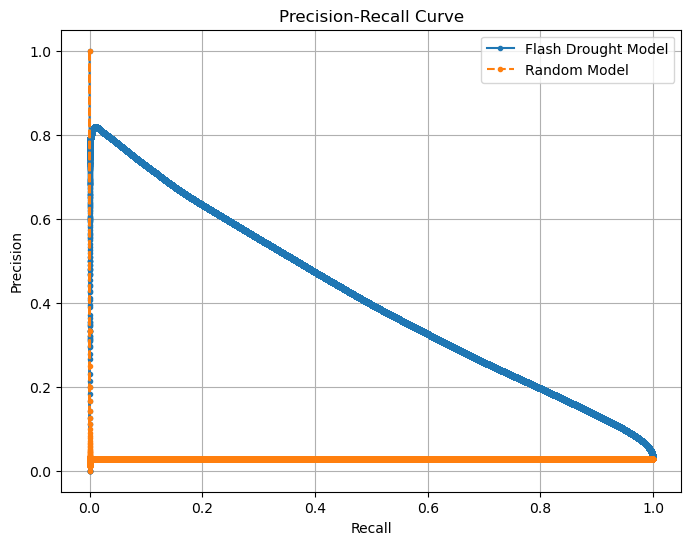

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Flash Drought Model')
plt.plot(recall_random, precision_random, marker='.', label='Random Model', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [38]:
year_wise_dataloader = []
start_position = 6141
for i in range(5):
    count = 365
    if (i + 2018) % 4 == 0:
        count += 1
    year_wise_dataloader.append(DataLoader(CustomDataset(start_position, count), batch_size=2, shuffle=False, num_workers=8))
    start_position += count
    # _, _, file_names = next(iter(year_wise_dataloader[-1]))
    # print(file_names)

In [39]:
for it, dataloader in enumerate(year_wise_dataloader):
    correct, recall, precision, recall_neg = get_metrics(dataloader)
    f1_score = calc_f1_score(recall, precision)
    print("[Year %d] Accuracy: %.4f, Recall: %.4f, Precision: %.4f, Recall_Neg: %.4f, F1_Score: %.4f" % (2018+it, 100*correct, 100*recall, 100*precision, 100*recall_neg, f1_score))

[Year 2002] Accuracy: 95.0184, Recall: 67.1256, Precision: 39.3738, Recall_Neg: 96.0771, F1_Score: 0.4963
[Year 2003] Accuracy: 92.0461, Recall: 66.5084, Precision: 33.5376, Recall_Neg: 93.3371, F1_Score: 0.4459
[Year 2004] Accuracy: 94.3191, Recall: 59.4360, Precision: 29.9045, Recall_Neg: 95.4567, F1_Score: 0.3979
[Year 2005] Accuracy: 96.3051, Recall: 61.1711, Precision: 13.9791, Recall_Neg: 96.6206, F1_Score: 0.2276
[Year 2006] Accuracy: 94.9310, Recall: 67.2227, Precision: 20.5945, Recall_Neg: 95.4206, F1_Score: 0.3153


In [40]:
year_wise_summer_dataloader = []
start_position = 5745
for i in range(6):
    count = 90
    if (i + 2017) % 4 == 0:
        count += 1
    year_wise_summer_dataloader.append(DataLoader(CustomDataset(start_position, count), batch_size=2, shuffle=False, num_workers=8))
    start_position += (count+275)
    # _, _, file_names = next(iter(year_wise_summer_dataloader[-1]))
    # print(file_names)

In [41]:
for it, dataloader in enumerate(year_wise_summer_dataloader):
    correct, recall, precision, recall_neg = get_metrics(dataloader)
    f1_score = calc_f1_score(recall, precision)
    print("[Year %d] Accuracy: %.4f, Recall: %.4f, Precision: %.4f, Recall_Neg: %.4f, F1_Score: %.4f" % (2016+it, 100*correct, 100*recall, 100*precision, 100*recall_neg, f1_score))

[Year 2016] Accuracy: 97.6529, Recall: 46.0520, Precision: 20.0742, Recall_Neg: 98.1684, F1_Score: 0.2796
[Year 2017] Accuracy: 91.8209, Recall: 75.9850, Precision: 55.7080, Recall_Neg: 93.5196, F1_Score: 0.6429
[Year 2018] Accuracy: 90.5561, Recall: 75.0006, Precision: 38.9315, Recall_Neg: 91.6590, F1_Score: 0.5126
[Year 2019] Accuracy: 93.0723, Recall: 50.3256, Precision: 29.3644, Recall_Neg: 94.8801, F1_Score: 0.3709
[Year 2020] Accuracy: 96.2634, Recall: 26.0963, Precision: 6.9523, Recall_Neg: 96.8885, F1_Score: 0.1098
[Year 2021] Accuracy: 94.3482, Recall: 78.3171, Precision: 26.1000, Recall_Neg: 94.7292, F1_Score: 0.3915


In [59]:
from sklearn.metrics import f1_score

In [60]:
check_dataloader = DataLoader(CustomDataset(6866, 10), batch_size=1, shuffle=False, num_workers=8)

In [61]:
all_labels = []
all_preds = []
all_file_name = []
all_f1_score = []

mask_sq = mask.squeeze().cpu()

with torch.no_grad():
    for inputs, labels, file_name in check_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(0)

        y_preds = model(inputs).squeeze(0)
        preds = y_preds > 0.5

        preds = preds * mask
        
        labels, preds = labels.squeeze().cpu(), preds.squeeze().cpu().int()

        all_labels.append(labels)
        all_preds.append(preds)
        all_file_name.append(file_name)
        
        labels, preds = labels[mask_sq].numpy(), preds[mask_sq].numpy()
        all_f1_score.append(f1_score(labels, preds))

        torch.cuda.empty_cache()

all_f1_score = np.array(all_f1_score)

In [62]:
max_index = np.argmax(all_f1_score)
print(max_index, all_f1_score[max_index])

8 0.43091334894613587


In [63]:
np.sort(all_f1_score)[::-1][:10]

array([0.43091335, 0.42483046, 0.41653715, 0.40996086, 0.39624633,
       0.39307203, 0.36582   , 0.34617874, 0.33828747, 0.3345129 ])

In [64]:
i = max_index
print(all_file_name[i])

('20200104.pt',)


In [65]:
print(torch.unique(all_labels[i], return_counts=True))
print(torch.unique(all_preds[i], return_counts=True))

(tensor([0., 1.]), tensor([264822,  10310]))
(tensor([0, 1], dtype=torch.int32), tensor([261103,  14029]))


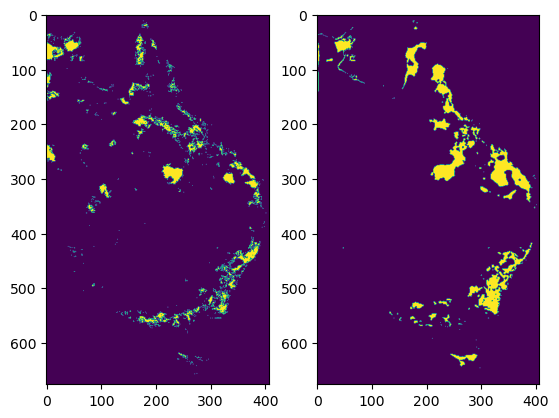

In [66]:
_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(all_labels[i])
axes[1].imshow(all_preds[i])

In [61]:
from PIL import Image

In [62]:
check_dataloader = DataLoader(CustomDataset(5410, 7967-5410), batch_size=4, shuffle=False)

In [63]:
with torch.no_grad():
    for inputs, _, file_names in tqdm(check_dataloader):
        inputs = inputs.to(device)

        y_preds = model(inputs).squeeze()
        y_preds = y_preds * mask
        preds = y_preds > 0.5

        for i, file_name in enumerate(file_names):
            np_array = preds[i].cpu().numpy()
            image = Image.fromarray((np_array * 255).astype(np.uint8))
            image.save(curr_folder + "prediction/" + file_name + ".tiff", format='TIFF')

100%|██████████| 640/640 [1:04:57<00:00,  6.09s/it]
